<a href="https://colab.research.google.com/github/2series/100_Days_of_ML_Code/blob/master/Surviving_The_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Infamous Doomed Sea Voyage Of 1912**

By examining factors such as class, sex, and age, I shall experiment with different machine learning algorithms and build a program that can predict whether a given passenger would have survived this disaster.

# **The Data At First Glance: Who Survived The Titanic And Why?**

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import random
import numpy as np
import pandas as pd
from sklearn import datasets, svm, cross_validation, tree, preprocessing, metrics
import sklearn.ensemble as ske
import tensorflow as tf
from tensorflow.contrib import learn as skflow

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from google.colab import files
files.upload()

Saving titanic3.xls to titanic3 (1).xls


{'titanic3.xls': b'\xd0\xcf\x11\xe0\xa1\xb1\x1a\xe1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00>\x00\x03\x00\xfe\xff\t\x00\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x05\x00\x00\x00)\x02\x00\x00\x00\x00\x00\x00\x00\x10\x00\x00\xfe\xff\xff\xff\x00\x00\x00\x00\xfe\xff\xff\xff\x00\x00\x00\x00$\x02\x00\x00%\x02\x00\x00&\x02\x00\x00\'\x02\x00\x00(\x02\x00\x00\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xf

In [3]:
!pip install xlrd

In [0]:
titanic_df = pd.read_excel('titanic3.xls', 'titanic3', index_col=None, na_values=['NA'])

In [0]:
titanic_df_original=titanic_df.copy()

In [6]:
titanic_df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


Now that we have the data in a dataframe, we can begin an advanced analysis of the data using powerful single-line Pandas functions. First, let’s examine the overall chance of survival for a Titanic passenger.

In [7]:
titanic_df.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

We see 3 dtypes:

*   object - variables are categorical i.e. string values
*   int64 - integer variable
*   float64 - variable which has a decimal value

In [8]:
titanic_df.shape

(1309, 14)

In [9]:
titanic_df['survived'].mean()

0.3819709702062643

# **OVERALL CHANCE OF SURVIVAL FOR A PASSENGER, 38%**

Not the best odds!
The reason for this massive loss of life is that the Titanic was only carrying **20 lifeboats**, which was not nearly enough for the **1,317 passengers and 885 crew members aboard**. It seems unlikely that all of the passengers would have had equal chances at survival, so we will continue breaking down the data to examine the social dynamics that determined who got a place on a lifeboat and who did not.

In [10]:
titanic_df.groupby('pclass').mean()

,survived,age,sibsp,parch,fare,body
pclass,,,,,,
1,0.619195,39.159918,0.436533,0.365325,87.508992,162.828571
2,0.429603,29.506705,0.393502,0.368231,21.179196,167.387097
3,0.255289,24.816367,0.568406,0.400564,13.302889,155.818182


Social classes were heavily stratified in the early twentieth century. This was especially true on the Titanic, where the luxurious first-class areas were completely off limits to the middle-class passengers in second class, and especially to those who carried a third class “economy price” ticket. To get a view into the composition of each class, I've group data by class, and view the averages for each column.

 some interesting insights from this data. For instance, passengers in first class had a 62% chance of survival, compared to a 25.5% chance for those in 3rd class. Additionally, the lower classes generally consisted of younger people, and the ticket prices for first class were predictably much higher than those for second and third class. The first class tickets ranged enormously in price, from $150 (about $1700 today) for a simple berth, up to $4350 ($50,000) for one of the two Parlour suites. Second class tickets were $60 (around $700) and third class passengers paid between $15 and $40 ($170 - £460) in 2018.
 

In [11]:
class_sex_grouping = titanic_df.groupby(['pclass','sex']).mean()
class_sex_grouping

survived        age     sibsp     parch        fare        body
pclass sex                                                                    
1      female  0.965278  37.037594  0.555556  0.472222  109.412385         NaN
       male    0.340782  41.029250  0.340782  0.279330   69.888385  162.828571
2      female  0.886792  27.499191  0.500000  0.650943   23.234827   52.000000
       male    0.146199  30.815401  0.327485  0.192982   19.904946  171.233333
3      female  0.490741  22.185307  0.791667  0.731481   15.324250  183.000000
       male    0.152130  25.962273  0.470588  0.255578   12.415462  151.854167

While the Titanic was sinking, the officers famously prioritized who was allowed in a lifeboat with the strict maritime tradition of evacuating women and children first. Our statistical results clearly reflect the first part of this policy as, across all classes, women were much more likely to survive than the men. We can also see that the women were younger than the men on average, were more likely to be traveling with family, and paid slightly more for their tickets.

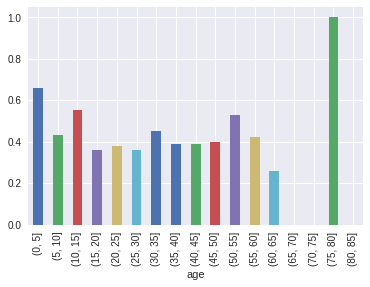

In [12]:
group_by_age = pd.cut(titanic_df["age"], np.arange(0, 90, 5))
age_grouping = titanic_df.groupby(group_by_age).mean()
age_grouping['survived'].plot.bar()

The effectiveness of the second part of this “Women and children first” policy can be deduced by breaking down the survival rate by age.

Here we can see that children were indeed the most likely age group to survive, although this percentage was still tragically below 60% for humans aged 6 and above.

# **Applying Machine Learning**

With analysis some fairly straightforward conclusions from the data can be deduced, namely, being a women, being in 1st class and being a child were all factors that could boost your chances of survival during this disaster.

# **Applying machine learning, a model that learns from the sample data to predict whether a given passenger would survive  may be determined**

In [13]:
titanic_df.count()

pclass       1309
survived     1309
name         1309
sex          1309
age          1046
sibsp        1309
parch        1309
ticket       1309
fare         1308
cabin         295
embarked     1307
boat          486
body          121
home.dest     745
dtype: int64

Most of the rows are missing values: "age",  "cabin", “boat” and "body". So, we'll remove these columns from the data frame. A large number of rows are also missing in “home.dest” field; here we fill the missing values with “NA”. **A significant number of rows are also missing an age value. We have seen above that age could have a significant effect on survival chances, so we'll have to drop all of rows that are missing an age value.**

**Cleaning The Data**

In [0]:
titanic_df = titanic_df.drop(['cabin','boat','body'], axis=1)

In [0]:
titanic_df["home.dest"] = titanic_df["home.dest"].fillna("NA")

In [0]:
titanic_df = titanic_df.dropna()

In [17]:
titanic_df.count()

pclass       1043
survived     1043
name         1043
sex          1043
age          1043
sibsp        1043
parch        1043
ticket       1043
fare         1043
embarked     1043
home.dest    1043
dtype: int64

Great! we can see that all remaining columns now contain the same number of values.

**Machine Learning Algorithm Required To Format The Remaining Data**

In [0]:
def preprocess_titanic_df(df):
    processed_df = df.copy()
    le = preprocessing.LabelEncoder()
    processed_df.sex = le.fit_transform(processed_df.sex)
    processed_df.embarked = le.fit_transform(processed_df.embarked)
    processed_df = processed_df.drop(['name','ticket','home.dest'],axis=1)
    return processed_df

In [0]:
processed_df = preprocess_titanic_df(titanic_df)

The “sex” and “embarked” fields are both string values that correspond to categories (i.e “Male” and “Female”) so we'll run each through a preprocessor. This preprocessor will convert these strings into integer values, making it easier for the classification algorithms to find patterns. For instance, “Female” and “Male” will be converted to 0 and 1 respectively. The “name”, “ticket”, and “home.dest” columns consist of non-categorical string values. These are difficult to use in a classification algorithm, so we will drop them from the data set.

In [0]:
X = processed_df.drop(['survived'], axis=1).values
y = processed_df['survived'].values

In [0]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size=0.2)

Next, we separate the data set into two arrays: “X” containing all of the values for each row besides “survived”, and “y” containing only the “survived” value for that row. The classification algorithms will compare the attribute values of “X” to the corresponding values of “y” to detect patterns in how different attributes values tend to affect the survival of a passenger.

Finally, we break the “X” and “y” array into two parts each — a training set and a testing set. We will feed the training set into the classification algorithm to form a trained model. Once the model is formed, we will use it to classify the testing set, allowing us to determine the accuracy of the model. Here we have made a 20/80 split, such that 80% of the dataset will be used for training and 20% will be used for testing.

# **Classification - The Exciting Part**

We'll start off with a simple decision tree classifier.  

A decision tree examines one variable at a time and splits into one of two branches based on the result of that value, at which point it does the same for the next variable.

# https://cdn.patricktriest.com/blog/images/posts/titanic-ml/decision-tree.png

# **Explaination of the link above**

The tree first splits by sex, and then by class, since it has learned during the training phase that these are the two most important features for determining survival. The dark blue boxes indicate passengers who are likely to survive, and the dark orange boxes represent passengers who are almost certainly doomed. Interestingly, after splitting by class, the main deciding factor determining the survival of women is the ticket fare that they paid, while the deciding factor for men is their age (with children being much more likely to survive).

In [0]:
clf_dt = tree.DecisionTreeClassifier(max_depth=10)

In [23]:
clf_dt.fit (X_train, y_train)
clf_dt.score (X_test, y_test)

0.8277511961722488

# **0.83, means that the model correctly predicted the survival of 83% of the test set.**

**Me being me, a skeptical reader, the accuracy of the model might vary depending on which rows were selected for the training and test sets. I'll get around this problem by using a shuffle validator.**

In [0]:
shuffle_validator = cross_validation.ShuffleSplit(len(X), n_iter=20, test_size=0.2, random_state=0)
def test_classifier(clf):
    scores = cross_validation.cross_val_score(clf, X, y, cv=shuffle_validator)
    print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std()))

In [25]:
test_classifier(clf_dt)

Accuracy: 0.7758 (+/- 0.02)


This shuffle validator applies the same random 20:80 split as before, but this time it generates 20 unique permutations of this split. By passing this shuffle validator as a parameter to the “cross_val_score” function, we can score our classifier against each of the different splits, and compute the average accuracy and standard deviation from the results.

# The result shows that our decision tree classifier has an overall accuracy of **78%**, although it can go up to 80% and down to 75% depending on the training/test split. Using scikit-learn, we can easily test other machine learning algorithms using the exact same syntax.

In [26]:
clf_rf = ske.RandomForestClassifier(n_estimators=50)
test_classifier(clf_rf)

Accuracy: 0.7806 (+/- 0.02)


The “Random Forest” classification algorithm will create a multitude of (generally very poor) trees for our data set using different random subsets of the input variables, and will return whichever prediction was returned by the most trees. This helps to avoid “overfitting”, a problem that occurs when a model is so tightly fitted to arbitrary correlations in the training data that it performs poorly on test data.

In [27]:
clf_gb = ske.GradientBoostingClassifier(n_estimators=50)
test_classifier(clf_gb)

Accuracy: 0.8201 (+/- 0.02)


The “Gradient Boosting” classifier will generate many weak, shallow prediction trees and will combine, or “boost”, them into a strong model. This model performs very well on our data set, but has the drawback of being relatively slow and difficult to optimize, as the model construction happens sequentially so it cannot be parallelized.



# **THESE ARE NOT JUST DATA POINTS, THEY'RE HUMANS**

Given that the accuracy for all of our models is maxing out around **80%**, it will be interesting to look at specific passengers for whom these classification algorithms are incorrect.

# **Initially I was disappointed by the accuracy of my machine learning models maxing out at about 80% for this data set. It’s easy to forget that these data points each represent real people, each of whom found themselves stuck on a sinking ship without enough lifeboats. When we looked into data points for which our model was wrong, we can uncover incredible stories of human nature driving people to defy their logical fate. It is important to never lose sight of the human element when analyzing this type of data set. This principle will be especially important going forward, as machine learning is increasingly applied to human data sets by organizations such as insurance companies, big banks, and law enforcement agencies.**